In [2]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

## Loading processed query, library and found_matches data

In [2]:
# load training dataset, for making these see notebook 1b

outfile = os.path.join(path_data, 'training_query_library_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        training_query_library_s2v_2dec = pickle.load(inf)
        old_and_unique_documents_query_s2v_2dec, old_and_unique_documents_library_s2v_2dec = training_query_library_s2v_2dec
else:
    with open(outfile, 'wb') as outf:
        training_query_library_s2v_2dec = (old_and_unique_documents_query_s2v_2dec, old_and_unique_documents_library_s2v_2dec)
        pickle.dump(training_query_library_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\training_query_library_s2v_2dec.pickle


In [3]:
#loading test dataset

outfile = os.path.join(path_data, 'testing_query_library_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        testing_query_library_s2v_2dec = pickle.load(inf)
        new_and_unique2_documents_query_s2v_2dec, new_and_unique2_documents_library_s2v_2dec = testing_query_library_s2v_2dec
else:
    with open(outfile, 'wb') as outf:
        testing_query_library_s2v_2dec = (new_and_unique2_documents_query_s2v_2dec, new_and_unique2_documents_library_s2v_2dec)
        pickle.dump(testing_query_library_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\testing_query_library_s2v_2dec.pickle


In [54]:
# load/make found_matches for both query and test set

# define models
path_models = os.path.join(path_data, "trained_models")
model_file2 = os.path.join(path_models, "spec2vec_library_testing_4000removed_2dec.model")

# check if output exists, if not: query models
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v_2dec = pickle.load(inf)
else:
    # load model
    model2 = gensim.models.Word2Vec.load(model_file2)
    print(model2)
    old_and_unique_found_matches_s2v_2dec = library_matching(old_and_unique_documents_query_s2v_2dec,
                                                             old_and_unique_documents_library_s2v_2dec,
                                                             model2,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v_2dec, outf)

outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v_2dec = pickle.load(inf)
else:
    # load model
    model2 = gensim.models.Word2Vec.load(model_file2)
    print(model2)
    new_and_unique2_found_matches_s2v_2dec = library_matching(new_and_unique2_documents_query_s2v_2dec,
                                                             new_and_unique2_documents_library_s2v_2dec,
                                                             model2,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v_2dec.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v_2dec.pickle


Max parent mass: 13418.370894192036


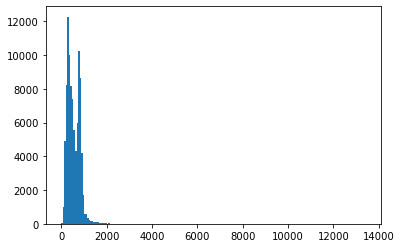

In [5]:
# get max parent mass in dataset
all_q_masses = [doc._obj.get("parent_mass") for doc in old_and_unique_documents_query_s2v_2dec]
all_l_masses = [doc._obj.get("parent_mass") for doc in old_and_unique_documents_library_s2v_2dec]
max_parent_mass = max(all_q_masses + all_l_masses)
print("Max parent mass:", max_parent_mass)
plt.hist(all_q_masses + all_l_masses, bins = 200)
plt.show()

## Get additional features

In [6]:
from rdkit import Chem, DataStructs

def find_info_matches(matches, documents_library, documents_query,
                      add_label = True, add_tanimoto_sim = True, add_cols = False,
                      add_num_matches_transform = True, add_mass_transform = True,
                      max_parent_mass = False, add_mass_similarity = True):
    '''
    To each df in matches, add more info like tanimoto scores vs query etc.
    
    A matching inchikey gets label 1 and non-matching 0.

    matches: list of pandas DataFrames, library matching result of query on library
    documents_library: list of SpectrumDocuments, spectra in library
    documents_query: list of SpectrumDocuments, spectra in query set.
        Indices should correspond to indices of matches.
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    add_label: bool, add a label for inchikey match or not
    add_tanimoto_sim: bool, add tanimoto similarity or not
    add_cols: bool/list of str, add other info present in metadata such as parent_mass, adduct
        default: False
    add_num_matches_transform: bool, transform cosine and mod_cosine matches to a number 0-1.
        both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    add_mass_transform: bool, add transform of the parent masses to a fraction of the maximal parent mass
    max_parent_mass: int/float, the maximum parent mass in the dataset, default = False
    add_mass_similarity: bool, add similarity of parent mass to the query as a scaled number from 0-1
        where The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
        1 - base_num^diff_in_dalton
    
    Output
    matches_with_info: list of pandas DataFrames, library matching result of query
        on library with matching labels
    '''
    matches_with_info = []
    if add_mass_transform and not max_parent_mass:
        print("If you want to transform the masses, please provide a max_parent_mass")
        return
    else:
        print('Max parent mass:', max_parent_mass)

    for query_id in range(len(documents_query)):
        match = matches[query_id].copy()
        if add_label:
            query_inchi = documents_query[query_id]._obj.get("inchikey")[:14]
            match = find_inchikey_match(match, documents_library, query_inchi)
        if add_cols:
            match = find_basic_info(match, documents_library, add_cols)
        if add_tanimoto_sim:
            query_smiles = documents_query[query_id]._obj.get("smiles")
            match = find_tanimoto_sim(match, documents_library, query_smiles)
        if add_num_matches_transform:
            match = transform_num_matches(match)
        if add_mass_transform:
            #add parent_mass if its not there already
            match = find_basic_info(match, documents_library, add_cols = ['parent_mass'])
            match['parent_mass'] = [cur_pm/max_parent_mass for cur_pm in match['parent_mass']]
        if add_mass_similarity:
            if 'mass_match' in match:
                match.drop(['mass_match'], axis=1, inplace=True)
            q_mass = documents_query[query_id]._obj.get("parent_mass")
            match = find_mass_similarity(match, documents_library, q_mass, base_num = 0.8)
        
        matches_with_info.append(match)
    return matches_with_info

def find_inchikey_match(matches, documents_library, query_inchi):
    '''To each match in the matches df, add label for matching inchikey (1) or non-matching (0)

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_inchi: str, first 14 symbols of query inchikey
    df: pandas DataFrame, library matching result of query on library with matching labels
    '''
    matches_with_labels = []
    df = matches.copy()
    library_ids = df.index.values
    labels = []
    for lib_id in library_ids:
        lib_inchi = documents_library[lib_id]._obj.get("inchikey")[:14]
        lab = 0
        if query_inchi == lib_inchi:
            lab = 1
        labels.append(lab)
    df['label'] = labels
    return df

def find_mass_matches(matches, documents_library, query_mass, bins = [2, 5], calc_change = False):
    '''
    To each match in matches df, add the mass change of query to match in bins or a percentage change

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    df: pandas DataFrame, library matching result of 1 query on library with mass matches
    '''
    range_bins = range(len(bins)) #calc once
    df = matches.copy()
    library_ids = df.index.values
    masses = [[] for _ in range_bins] #initialise
    mass_changes = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        if calc_change: #calculate a percentage change in parent mass instead of discrete bins
            perc_change = abs(lib_mass - query_mass) / query_mass * 100
            mass_changes.append(perc_change)
        else:
            for bin_i in range_bins:
                cutoff = bins[bin_i]
                lab = 0
                if abs(query_mass - lib_mass) < cutoff:
                    lab = 1
                masses[bin_i].append(lab)
    #add to df
    if calc_change:
        df['perc_mass_change'] = mass_changes
    else:
        for bin_i in range_bins:
            df['mass_match_' + str(bins[bin_i])] = masses[bin_i]
    return df

def find_basic_info(matches, documents_library, add_cols = ['parent_mass']):
    '''
    To each match in matches df, add the info from add_cols entries

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with added info
    '''
    df = matches.copy()
    library_ids = df.index.values
    if add_cols:
        for col in add_cols:
            col_data = []
            for lib_id in library_ids:
                lib_data = documents_library[lib_id]._obj.get(col)
                col_data.append(lib_data)
            df[col] = col_data
    return df

def find_tanimoto_sim(matches, documents_library, query_smiles):
    '''To each match in matches df, add the tanimoto similarity between query and match

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with tanimoto similarities
    '''
    df = matches.copy()
    sims = []
    library_ids = df.index.values
    
    if not query_smiles or query_smiles == "None": # check that query smiles exist
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    ms_q = Chem.MolFromSmiles(query_smiles)
    if not ms_q: #in case something is wrong with smiles
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    
    fp_q = Chem.RDKFingerprint(ms_q)
    for lib_id in library_ids:
        smiles_lib = documents_library[lib_id]._obj.get("smiles")
        if smiles_lib and smiles_lib != "None":
            ms_lib = Chem.MolFromSmiles(smiles_lib)
            if ms_lib:
                fp_lib = Chem.RDKFingerprint(ms_lib)
                score = DataStructs.FingerprintSimilarity(fp_q, fp_lib)
            else: #in case something is wrong with smiles
                score = 0
        else: #in case it doesnt have smiles
            score = 0
        sims.append(score)
    df['similarity'] = sims
    return df

def transform_num_matches(input_df, exp = 0.93):
    '''Transform the cosine_matches and mod_cosine_matches to between 0-1
    
    input_df: pandas DataFrame, spec2vec matches for one query
    exp: int, the base for the exponential, default: 0.93
    
    Both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    '''
    df = input_df.copy() #otherwise it edits the df outside the function
    df['cosine_matches'] = [(1-0.93**i) for i in df['cosine_matches']]
    df['mod_cosine_matches'] = [(1-0.93**i) for i in df['mod_cosine_matches']]
    return df

def find_mass_similarity(matches, documents_library, query_mass, base_num = 0.8):
    '''
    To each match in matches df, add a scaled value for how similar the parent_mass is to the query

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    base_num: float, the base for the exponent
    df: pandas DataFrame, library matching result of 1 query on library with mass sims
    
    The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
    1 - base_num^diff_in_dalton
    '''
    df = matches.copy()
    library_ids = df.index.values
    scaled_mass_sims = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        mass_diff = abs(lib_mass - query_mass)
        scaled_mass_sim = base_num ** mass_diff
        scaled_mass_sims.append(scaled_mass_sim)

    #add to df
    df['mass_sim'] = scaled_mass_sims
    return df

In [7]:
# get top20
old_and_unique_found_matches_s2v_2dec_top20 = []

for matches in old_and_unique_found_matches_s2v_2dec:
    old_and_unique_found_matches_s2v_2dec_top20.append(
    matches.sort_values("s2v_score", ascending=False).iloc[:20])

In [3]:
outfile = os.path.join(path_data, 'nn_prep_training_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_training_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_prep_training_found_matches_s2v_2dec = find_info_matches(old_and_unique_found_matches_s2v_2dec_top20,
                                                                old_and_unique_documents_library_s2v_2dec,
                                                                old_and_unique_documents_query_s2v_2dec,
                                                                max_parent_mass=max_parent_mass)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_training_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_training_found_matches_s2v_2dec.pickle


In [9]:
# get top20
new_and_unique2_found_matches_s2v_2dec_top20 = []

for matches in new_and_unique2_found_matches_s2v_2dec:
    new_and_unique2_found_matches_s2v_2dec_top20.append(
    matches.sort_values("s2v_score", ascending=False).iloc[:20])

In [4]:
outfile = os.path.join(path_data, 'nn_prep_testing_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_testing_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_prep_testing_found_matches_s2v_2dec = find_info_matches(new_and_unique2_found_matches_s2v_2dec_top20,
                                                                new_and_unique2_documents_library_s2v_2dec,
                                                                new_and_unique2_documents_query_s2v_2dec,
                                                                max_parent_mass=max_parent_mass)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_testing_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_testing_found_matches_s2v_2dec.pickle


In [5]:
nn_prep_testing_found_matches_s2v_2dec[2].iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim
22101,0.928457,0.663299,0.928457,0.663299,0.909346,1,1.000000,0.034743,0.999777
20538,0.856661,0.549896,0.856661,0.549896,0.859138,1,1.000000,0.034743,1.000000
22454,0.857507,0.549896,0.857507,0.549896,0.674490,1,1.000000,0.034743,1.000000
1366,0.389183,0.549896,0.389183,0.549896,0.584506,1,1.000000,0.034744,0.999554
5998,0.336160,0.070000,0.337487,0.195643,0.303197,0,0.581808,0.037051,0.000997


## Add matches together for each query

In [22]:
# add all the found matches together in one big df
nn_training_found_matches_s2v_2dec = nn_prep_training_found_matches_s2v_2dec[0].append(
    nn_prep_training_found_matches_s2v_2dec[1:])
nn_training_found_matches_s2v_2dec = nn_training_found_matches_s2v_2dec.sample(frac=1)

nn_testing_full_found_matches_s2v_2dec = nn_prep_testing_found_matches_s2v_2dec[0].append(
    nn_prep_testing_found_matches_s2v_2dec[1:])
nn_testing_full_found_matches_s2v_2dec = nn_testing_full_found_matches_s2v_2dec.sample(frac=1)


# take 300 (randomly chosen) query matches for validation set
np.random.seed(42)
first_half = list(np.random.choice(range(0,1000), 250, replace=False))
np.random.seed(42)
second_half = list(np.random.choice(range(1000,2000), 250, replace=False))
val_set = first_half + second_half
nn_val_found_matches_s2v_2dec = pd.DataFrame()
nn_testing_found_matches_s2v_2dec = pd.DataFrame()

for i in range(len(nn_prep_testing_found_matches_s2v_2dec)):
    if i in val_set:
        nn_val_found_matches_s2v_2dec = nn_val_found_matches_s2v_2dec.append(nn_prep_testing_found_matches_s2v_2dec[i])
    else:
        nn_testing_found_matches_s2v_2dec = nn_testing_found_matches_s2v_2dec.append(nn_prep_testing_found_matches_s2v_2dec[i])

nn_val_found_matches_s2v_2dec = nn_val_found_matches_s2v_2dec.sample(frac=1)
nn_testing_found_matches_s2v_2dec = nn_testing_found_matches_s2v_2dec.sample(frac=1)

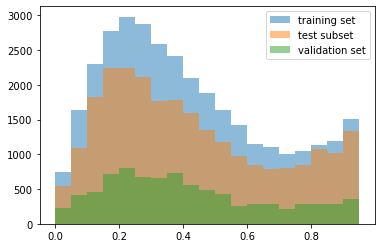

In [6]:
plt.hist(nn_training_found_matches_s2v_2dec['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'training set')
plt.hist(nn_testing_found_matches_s2v_2dec['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'test subset')
plt.hist(nn_val_found_matches_s2v_2dec['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'validation set')
plt.legend()
plt.show()

In [23]:
X_train = nn_training_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_train = nn_training_found_matches_s2v_2dec['similarity']
X_test = nn_testing_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_test = nn_testing_found_matches_s2v_2dec['similarity']
X_val = nn_val_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
y_val = nn_val_found_matches_s2v_2dec['similarity']

## Training RF

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# train rf
num_est = 250
rf = RandomForestRegressor(n_estimators = num_est, random_state = 42, max_depth = 5)
rf.fit(X_train, y_train)

# predict on train
rf_train_predictions = rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, rf_train_predictions)
print('Training MSE', mse_train_rf)

# predict on test
rf_predictions = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, rf_predictions)
print('Validation MSE', mse_rf)

# get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Training MSE 0.049800809392068046
Validation MSE 0.05047421650180994
Variable: s2v_score            Importance: 0.38
Variable: mass_sim             Importance: 0.23
Variable: parent_mass          Importance: 0.21
Variable: mod_cosine_matches   Importance: 0.14
Variable: cosine_matches       Importance: 0.03
Variable: cosine_score         Importance: 0.0
Variable: mod_cosine_score     Importance: 0.0


[None, None, None, None, None, None, None]

### Optimising RF parameters
- training and val loss seem very far apart -> overfitting in some way

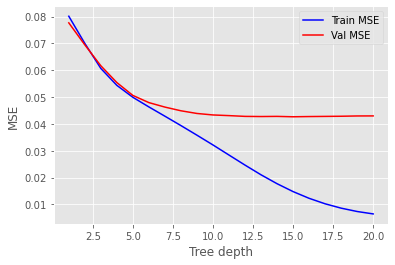

In [64]:
# find good max_depth -> 5 (see plot)
to_try = range(1, 21)
num_est = 40

train_mse = []
val_mse = []
for try_maxd in to_try:
    rf2 = RandomForestRegressor(n_estimators = num_est, random_state = 42, max_depth = try_maxd)
    rf2.fit(X_train, y_train)

    # predict on train
    rf_train_predictions2 = rf2.predict(X_train)
    mse_train_rf2 = mean_squared_error(y_train, rf_train_predictions2)
#     print('Training MSE', mse_train_rf2)
    train_mse.append(mse_train_rf2)
    # predict on test
    rf_predictions2 = rf2.predict(X_val)
    mse_rf2 = mean_squared_error(y_val, rf_predictions2)
#     print('Validation MSE', mse_rf2)
    val_mse.append(mse_rf2)

plt.plot(to_try, train_mse, "b", label="Train MSE")
plt.plot(to_try, val_mse, "r", label="Val MSE")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Tree depth")
plt.show()

50 9.832176208496094
100 19.46282410621643
250 59.83411455154419
500 132.64440441131592
1000 308.5162515640259
1500 184.54904007911682


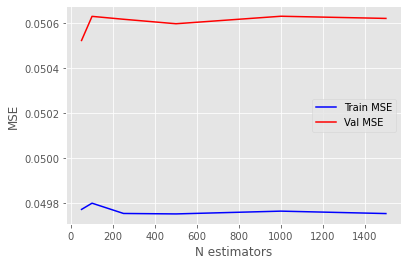

In [65]:
# find good nodes
import time
to_try = [50,100,250,500,1000,1500]

train_mse = []
val_mse = []
for try_ns in to_try:
    start = time.time()
    rf2 = RandomForestRegressor(n_estimators = try_ns, random_state = 42, max_depth = 5)
    rf2.fit(X_train, y_train)
    end = time.time()
    elapsed = end-start
    print(try_ns, elapsed)
    # predict on train
    rf_train_predictions2 = rf2.predict(X_train)
    mse_train_rf2 = mean_squared_error(y_train, rf_train_predictions2)
#     print('Training MSE', mse_train_rf2)
    train_mse.append(mse_train_rf2)
    # predict on test
    rf_predictions2 = rf2.predict(X_val)
    mse_rf2 = mean_squared_error(y_val, rf_predictions2)
#     print('Validation MSE', mse_rf2)
    val_mse.append(mse_rf2)

plt.plot(to_try, train_mse, "b", label="Train MSE")
plt.plot(to_try, val_mse, "r", label="Val MSE")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("N estimators")
plt.show()

In [10]:
nn_rf_predict_found_matches_s2v_2dec = []
for ID in range(len(nn_prep_testing_found_matches_s2v_2dec)):
    current_match = nn_prep_testing_found_matches_s2v_2dec[ID].copy()
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions = rf.predict(predict_on)
    current_match['rf_predictions'] = predictions
    nn_rf_predict_found_matches_s2v_2dec.append(current_match)

In [11]:
nn_rf_predict_found_matches_s2v_2dec[5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,rf_predictions
18625,0.093364,0.0700,0.093364,0.070000,0.306735,0,0.323934,0.069334,2.747835e-68,0.358800
18631,0.093364,0.0700,0.093364,0.070000,0.303958,0,0.323934,0.034521,5.104856e-23,0.311354
7299,0.355064,0.1351,0.355068,0.195643,0.292372,0,0.414251,0.015286,1.897516e-03,0.182476
18626,0.093364,0.0700,0.093364,0.070000,0.290061,0,0.323934,0.068143,9.705796e-67,0.358800
18627,0.093364,0.0700,0.093364,0.070000,0.274596,0,0.323934,0.067774,2.933035e-66,0.358800
92968,0.000000,0.0000,0.000000,0.000000,0.272369,0,0.119211,0.014083,5.186006e-05,0.181458
64763,0.000000,0.0000,0.000000,0.000000,0.272369,0,0.120513,0.014083,5.186006e-05,0.181458
18628,0.093364,0.0700,0.093364,0.070000,0.262923,0,0.323934,0.033253,2.280202e-21,0.311354
58180,0.000000,0.0000,0.000000,0.000000,0.255365,0,0.120513,0.014083,5.186006e-05,0.181458
19223,0.000000,0.0000,0.169412,0.070000,0.252203,0,0.267964,0.018184,8.961955e-02,0.258783


## Training NN

In [12]:
#nn function
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

def train_nn(X_train, y_train, X_test, y_test, layers = [12, 12, 12, 12, 12, 1],
             model_loss = 'binary_crossentropy', activations = 'relu',
             last_activation = 'sigmoid', model_epochs = 20, model_batch_size = 16,
             save_name = False):
    '''Train a keras deep NN and test on test data, returns (model, history, accuracy, loss)
    
    X_train: matrix like object like pd.DataFrame, training set
    y_train: list like object like np.array, training labels
    X_test: matrix like object like pd.DataFrame, test set
    y_test: list like object like np.array, test labels
    layers: list of ints, the number of layers is the len of this list while the elements
        are the amount of neurons per layer, default: [12, 12, 12, 12, 12, 1]
    model_loss: str, loss function, default: binary_crossentropy
    activations: str, the activation of the layers except the last one, default: relu
    last_activation: str, activation of last layer, default: sigmoid
    model_epochs: int, number of epochs, default: 20
    model_batch_size: int, batch size for updating the model, default: 16
    save_name: str, location for saving model, optional, default: False
    
    Returns:
    model: keras sequential
    history: dict, training statistics
    accuracy: float, accuracy on test set
    loss, float, loss on test set
    
    If save_name is not False and save_name exists this function will load existing model
    '''
    if os.path.exists(save_name) and save_name:
        print('\nLoading existing model')
        nn_model = load_model(save_name)
        with open(save_name + '_train_hist.pickle', 'rb') as hist_inf:
            history = pickle.load(hist_inf)
    else:
        # define the keras model
        nn_model = Sequential()
        #add first layer
        nn_model.add(Dense(layers[0], input_dim = X_train.shape[1], activation = activations))
        #add other layers
        for i in range(1,len(layers)-1): #skip first and last one
            nn_model.add(Dense(layers[i], activation = activations))
        #add last layer
        nn_model.add(Dense(layers[-1], activation = last_activation))
        # compile the keras model
        nn_model.compile(loss = model_loss, optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        hist = nn_model.fit(X_train, y_train, epochs = model_epochs, batch_size = model_batch_size)
        history = hist.history
    
    #training set
    print('Training loss: {:.4f}\n'.format(history['loss'][-1]))
    
    #test set    
    loss, accuracy = nn_model.evaluate(X_test, y_test)
    print('Test accuracy: {:.2f}'.format(accuracy*100))
    print('Test loss: {:.4f}'.format(loss))
    
    if save_name and not os.path.exists(save_name):
        print('Saving model at:', save_name)
        nn_model.save(save_name)
        with open(save_name + '_train_hist.pickle', 'wb') as hist_outf:
            pickle.dump(history, hist_outf)
    
    return nn_model, history, accuracy, loss

In [13]:
test_layers = [10,24,1]
#model_name = os.path.join(path_data, 'nn_2000_queries_top20_1')
model_name = os.path.join(path_data, 'nn_2000_queries_top20_layers_opt_1') #this one tested best in notebook 3

# X_tanimoto_top20 = nn_training_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
# y_tanimoto_top20 = nn_training_found_matches_s2v_2dec['similarity']
# X_tanimoto_top20_test = nn_testing_found_matches_s2v_2dec.drop(['similarity', 'label'], axis = 1)
# y_tanimoto_top20_test = nn_testing_found_matches_s2v_2dec['similarity']

nn_2000_queries_top20_1 = train_nn(X_train, y_train, X_test, y_test, layers = test_layers,
         model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
         model_epochs = 50, model_batch_size = 16, save_name = model_name)


Loading existing model
Training loss: 0.0493

30000/30000 [==============================] - 2s 54us/sample - loss: 0.0502 - accuracy: 0.1053
Test accuracy: 10.53
Test loss: 0.0502


In [20]:
from tensorflow.keras.models import Sequential, load_model

best_model_name = os.path.join(path_data, 'nn_2000_queries_trimming_simple_10.hdf5')
best_model = load_model(best_model_name)

In [24]:
best_model.evaluate(X_test, y_test)

30000/30000 [==============================] - 1s 43us/sample - loss: 0.0488 - mae: 0.1706


[0.04878429824113846, 0.17055081]

## Querying test set on model

In [14]:
outfile = os.path.join(path_data, 'nn_tested_found_matches_s2v_2dec.pickle')
#query and library of the test data can be found (as a tuple of (query, library)) in testing_query_library_s2v_2dec.pickle
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_tested_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_tested_found_matches_s2v_2dec = []
    for ID in range(len(nn_prep_testing_found_matches_s2v_2dec)):
        current_match = nn_prep_testing_found_matches_s2v_2dec[ID].copy()
        predict_on = current_match.drop(['label', 'similarity'], axis = 1)
        predictions = nn_2000_queries_top20_1[0].predict(predict_on)
        current_match['sim_predictions'] = predictions
        nn_tested_found_matches_s2v_2dec.append(current_match)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_tested_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_tested_found_matches_s2v_2dec.pickle


In [25]:
outfile = os.path.join(path_data, 'nn_best_model_found_matches_s2v_2dec.pickle')
#query and library of the test data can be found (as a tuple of (query, library)) in testing_query_library_s2v_2dec.pickle
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_best_model_found_matches_s2v_2dec = pickle.load(inf)
else:
    nn_best_model_found_matches_s2v_2dec = []
    for ID in range(len(nn_prep_testing_found_matches_s2v_2dec)):
        current_match = nn_prep_testing_found_matches_s2v_2dec[ID].copy()
        predict_on = current_match.drop(['label', 'similarity'], axis = 1)
        predictions = best_model.predict(predict_on)
        current_match['sim_predictions'] = predictions
        nn_best_model_found_matches_s2v_2dec.append(current_match)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_best_model_found_matches_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\nn_best_model_found_matches_s2v_2dec.pickle


In [26]:
nn_tested_found_matches_s2v_2dec[0].iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,sim_predictions
1639,0.000052,0.251948,0.000107,0.440418,0.481348,0,0.618732,0.109013,1.326203e-39,0.450711
3005,0.000169,0.070000,0.000169,0.070000,0.471357,0,0.483736,0.093364,2.963293e-19,0.440107
4364,0.016219,0.353010,0.016285,0.549896,0.456992,0,0.635606,0.073968,2.023195e-07,0.477650
26600,0.000075,0.135100,0.022880,0.195643,0.439868,0,0.670978,0.085979,1.187375e-09,0.442850
6633,0.001208,0.070000,0.001212,0.135100,0.439756,0,0.383291,0.066811,9.974635e-17,0.449107


In [27]:
nn_best_model_found_matches_s2v_2dec[0].iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,similarity,parent_mass,mass_sim,sim_predictions
1639,0.000052,0.251948,0.000107,0.440418,0.481348,0,0.618732,0.109013,1.326203e-39,0.482210
3005,0.000169,0.070000,0.000169,0.070000,0.471357,0,0.483736,0.093364,2.963293e-19,0.500722
4364,0.016219,0.353010,0.016285,0.549896,0.456992,0,0.635606,0.073968,2.023195e-07,0.514977
26600,0.000075,0.135100,0.022880,0.195643,0.439868,0,0.670978,0.085979,1.187375e-09,0.469464
6633,0.001208,0.070000,0.001212,0.135100,0.439756,0,0.383291,0.066811,9.974635e-17,0.430324


In [48]:
# combine with rf score
nn_scores_rf_nn_found_matches_s2v_2dec = []
for ID in range(len(nn_best_model_found_matches_s2v_2dec)):
    current_match = nn_best_model_found_matches_s2v_2dec[ID].copy()
    current_match["rf_predictions"] = nn_rf_predict_found_matches_s2v_2dec[ID]["rf_predictions"]
    nn_scores_rf_nn_found_matches_s2v_2dec.append(current_match)

In [59]:
nn_scores_rf_nn_found_matches_s2v_2dec[2]
new_and_unique2_found_matches_s2v_2dec[2].sort_values("s2v_score", ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score
22101,0.928457,15,0.928457,15,0.909346
20538,0.856661,11,0.856661,11,0.859138
22454,0.857507,11,0.857507,11,0.674490
1366,0.389183,11,0.389183,11,0.584506
5998,0.336160,1,0.337487,3,0.303197
...,...,...,...,...,...
11071,0.009762,1,0.079068,3,0.178408
84725,0.000692,1,0.002880,4,0.178206
7971,0.000000,0,0.000000,0,0.178070
19586,0.000000,0,0.000000,0,0.178032


## Making well known performance plot

In [50]:
#testing if top hit is above 0.6 similarity
#look at top20
test_tan_nn_top20 = []
test_sim_mcos = []
test_sim_s2v = []
ideal_case_top20 = []
test_tan_rf_top20 = []
test_nn_rf_top20 = []

pred_thresh = 0.6
mass_sim_thresh = 0.000705
restr_nn = False # do mass+spec2vec restricitons on nn models
highest_pred = False # take highest prediction instead of first prediction over threshold
threshold = 0.4
topn = 20 #only look at top 20
sim_threshold = 0.6
mc_matches_thresh = 0.35 # mod cosine matches threshold corresponds to min match 6

for ID in range(len(nn_scores_rf_nn_found_matches_s2v_2dec)):
    if ID in val_set:
        continue
    # mass + mod cosine
    current_match = nn_scores_rf_nn_found_matches_s2v_2dec[ID]\
                        .sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['mod_cosine_score'] > threshold)
                                  & (current_match['mod_cosine_matches'] > mc_matches_thresh)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_mcos.append(best_bet)

    # Scenario 1: mass + Spec2Vec + threshold
    current_match = nn_scores_rf_nn_found_matches_s2v_2dec[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    #inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    #current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_s2v.append(best_bet)
    
    # Scenario 3: (Spec2Vec + threshold) after filtering for non-similar matches with nn
    if not restr_nn:
        df_select = current_match[(current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['sim_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_tan_nn_top20.append(best_bet)
    
    # ideal case: how many queries have an actual match above s2v threshold and >0.6 tanimoto
    df_select = current_match[(current_match['s2v_score'] > threshold)]
    best_bet = -1
    if df_select.shape[0] > 0:
        if any(df_select['similarity'] > 0.6):
            best_bet = 1
    ideal_case_top20.append(best_bet)
    
    # Scenario RF: filter with trained random forest model
    if not restr_nn:
        df_select = current_match[(current_match['rf_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['rf_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['rf_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_tan_rf_top20.append(best_bet)
    
    # Scenario NN+RF: filter with both models
    if not restr_nn:
        df_select = current_match[(current_match['rf_predictions'] >= pred_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['rf_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)
                                      & (current_match['sim_predictions'] >= pred_thresh)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['rf_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_nn_rf_top20.append(best_bet)
    
    
test_tan_nn_top20_arr = np.array(test_tan_nn_top20)
test_sim_mcos_arr = np.array(test_sim_mcos)
test_sim_s2v_arr = np.array(test_sim_s2v)
ideal_case_top20_arr = np.array(ideal_case_top20)
test_tan_rf_top20_arr = np.array(test_tan_rf_top20)
test_nn_rf_top20_arr = np.array(test_nn_rf_top20)

Text(0.5, 1.0, 'Compare if top hit is >= 0.6 tanimoto similarity\n(2000 query dataset)')

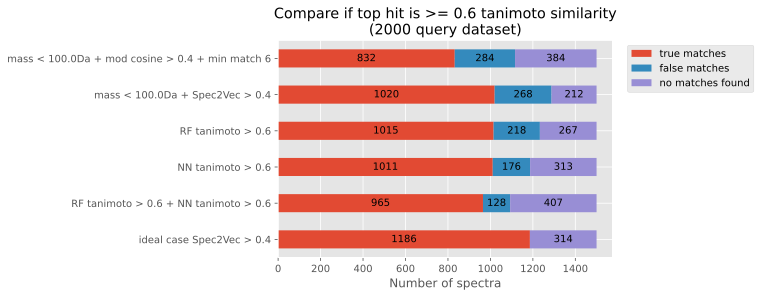

In [51]:
from math import log
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.style.use('ggplot')
da_diff = log(mass_sim_thresh, 0.93)

if restr_nn:
    ylabels = ['mass < {:.1f}Da + mod cosine > {} + min match 6'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {}'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {} + NN tanimoto > {}'.format(da_diff, threshold, pred_thresh),
               'ideal case Spec2Vec > {}'.format(threshold),
               'mass < {:.1f}Da + Spec2Vec > {} + RF tanimoto > {}'.format(da_diff, threshold, pred_thresh),
               'mass < {:.1f}Da + Spec2Vec > {} + RF tanimoto > {} + NN tanimoto > {}'.format(da_diff, threshold, pred_thresh, pred_thresh),]
else:
    ylabels = ['mass < {:.1f}Da + mod cosine > {} + min match 6'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {}'.format(da_diff, threshold),
               'NN tanimoto > {}'.format(pred_thresh),
               'ideal case Spec2Vec > {}'.format(threshold),
               'RF tanimoto > {}'.format(pred_thresh),
               'RF tanimoto > {} + NN tanimoto > {}'.format(pred_thresh, pred_thresh),]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_sim_mcos_arr == 1), np.sum(test_sim_mcos_arr == 0), np.sum(test_sim_mcos_arr == -1)],
                 [np.sum(test_sim_s2v_arr == 1), np.sum(test_sim_s2v_arr == 0), np.sum(test_sim_s2v_arr == -1)],
                 [np.sum(test_tan_nn_top20_arr == 1), np.sum(test_tan_nn_top20_arr == 0), np.sum(test_tan_nn_top20_arr == -1)],
                 [np.sum(ideal_case_top20_arr == 1), np.sum(ideal_case_top20_arr == 0), np.sum(ideal_case_top20_arr == -1)],
                 [np.sum(test_tan_rf_top20_arr == 1), np.sum(test_tan_rf_top20_arr == 0), np.sum(test_tan_rf_top20_arr == -1)],
                 [np.sum(test_nn_rf_top20_arr == 1), np.sum(test_nn_rf_top20_arr == 0), np.sum(test_nn_rf_top20_arr == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none', figsize=(6, 4))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if width != 0:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center', size=10)

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Compare if top hit is >= {} tanimoto similarity\n(2000 query dataset)'.format(sim_threshold))
#plt.figure(figsize=(5,5))
# plt.savefig(os.path.join(path_data, "Plots", "Performance_plot_ML_2000_queries.svg"))

## Redo some additional plots from earlier notebooks

In [ ]:
#if top hit is not true match, what is the average similarity of top hit above a threshold?
topn = 20
threshold = 0.4
false_m_simils_thresh = []
ids_top_false_hits_thresh = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    df_select = df_select[(df_select['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        top_hit = df_select.iloc[0]
        if top_hit['label'] == 0:
            false_m_simil = top_hit['similarity']
            print(ID,false_m_simil)
            ids_top_false_hits_thresh.append(ID)
            false_m_simils_thresh.append(false_m_simil)
print(len(false_m_simils_thresh))